In [49]:
import numpy as np
import matplotlib.pyplot as plt
import helpers.cusplot as cplt


## constants (SI)

In [56]:
# kicker
brho = 1.23 
lgap = 0.1
kick_l = 0.5
N = 20
u0 = 4*np.pi*1e-7

l = 3 # dist. kicker-septum

# charge distribution
sigma = 0.015
delta_x_max = 0.01

# septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

In [47]:
# numeric integration of current fraction 
# incident on septum
d = {}

for delta_x in np.linspace(0,delta_x_max,10):
    I = 0
    for step in np.linspace(2*sigma-w/2, 2*sigma + w/2,10):
        I += np.exp(-(step-delta_x)**2/(2*sigma**2))*w/10
    
    I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I
    
    d[delta_x] = I_norm

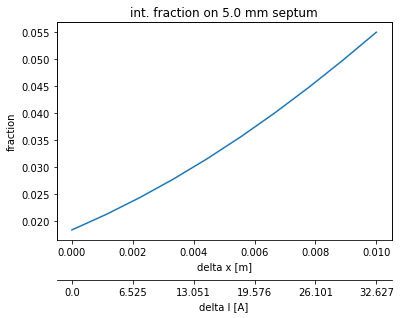

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(*zip(*sorted(d.items())))
ax.set_xlabel('delta x [m]')
ax.set_ylabel('fraction')

ax.set_title('int. fraction on {} mm septum'.format(w*1e3))

#convert spat. to curr_off
def dx_to_dI(dx):
    dThet = dx/l
    dI = brho*lgap/(u0*kick_l*N)*dThet
    return round(dI,3)

cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A]' )

plt.show()